In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

output_df = pd.read_csv("csv-files/CLs_predictions_vs_targets_6l_128n_0.005lr.csv")
sorted_output_df = output_df.sort_values(by="Targets")

In [4]:
# Store predictions and targets in separate arrays
predictions = sorted_output_df["Predictions"].values
targets = sorted_output_df["Targets"].values

# Output MAE and absolute mean of targets
print(f"MAE: {(np.abs(predictions-targets)).mean()}")
print(f"Absolute mean of targets: {(np.abs(targets)).mean()}")

MAE: 0.10839630239289547
Absolute mean of targets: 0.6020093681426797


In [3]:
def plot_incorrect_rejections_by_cutoff(true_values, predicted_values, num_points=100):

    # Create array of correctly rejected models. 0.12 is used because this is the true upper limit for relic density
    true_cutoff = (np.log(0.12) - mean_DM) / std_DM
    target_rejections = true_values > true_cutoff
    correct_accepted = np.logical_not(target_rejections)
    
    # Create array of test cutoffs
    test_cutoffs = np.linspace(predictions.min(),predictions.max(),num=num_points)
 
    # Create array of incorrect rejections that we will plot
    incorrect_rejections = []
    total_rejections = []

    for cutoff in test_cutoffs:

        # Work out which predictions are rejected by chosen cutoff
        rejected_predictions = predicted_values > cutoff
        
        # Calculate fraction of models that should have been accepted but were rejected
        total_wrongly_rejected = (rejected_predictions > target_rejections).sum()
        fraction_wrongly_rejected = total_wrongly_rejected / correct_accepted.sum()
        
        # Calculate fraction of correctly rejected models
        fraction_rejeceted = rejected_predictions.sum() / len(true_values)
        
        incorrect_rejections.append(fraction_wrongly_rejected)
        total_rejections.append(fraction_rejeceted)
    
    # Plot fraction of rejected models against cutoff
    plt.figure(figsize=(8, 6))
    plt.plot(test_cutoffs, incorrect_rejections)
    plt.plot(test_cutoffs, total_rejections)
    plt.xlabel("Cutoff")
    plt.ylabel("Fraction of models")
    plt.grid(axis='y', linestyle='--')
    plt.legend(["Fraction of models wrongly rejected (lower is better)", "Fraction of total models rejected (higher is better)"])
    plt.title("Fraction of models rejected against relic density cutoff")
    plt.show()

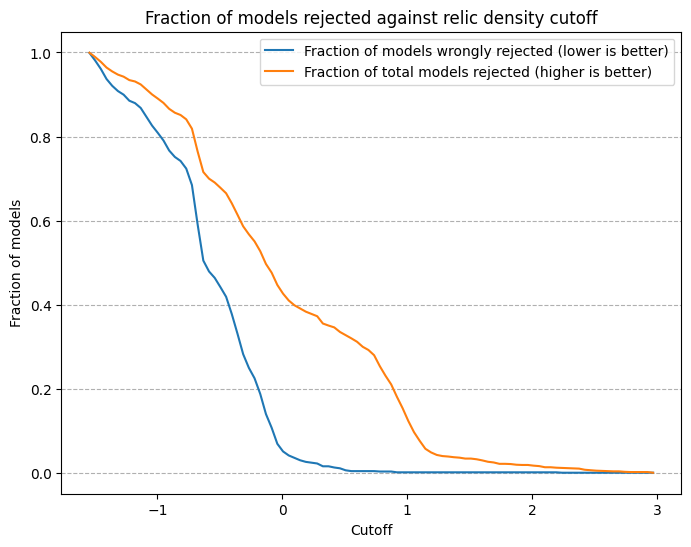

In [4]:
plot_incorrect_rejections_by_cutoff(targets, predictions)

In [73]:
def plot_mae_by_bins(true_values, predicted_values, num_bins):
    
    # Calculate absolute errors
    abs_errors = np.abs(true_values - predicted_values)
    
    # Create bins
    bins = np.linspace(true_values.min(), true_values.max(), num_bins + 1)
    
    # Compute mean absolute error for each bin
    mae_by_bin = []
    bin_centers = []
    
    for i in range(num_bins):
        # Find indices of values in this bin. Unnecessary given targets are sorted 
        bin_mask = (true_values >= bins[i]) & (true_values < bins[i+1])
        
        # Calculate MAE for this bin
        if np.sum(bin_mask) > 0:
            mae = np.mean(abs_errors[bin_mask])
            mae_by_bin.append(mae)
            bin_centers.append((bins[i] + bins[i+1]) / 2)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, mae_by_bin, width=(bins[1]-bins[0])*0.9)
    
    plt.title('Mean Absolute Error by True Relic Density Bins')
    plt.xlabel('True Relic Density (normalised log scale)')
    plt.ylabel('Mean Absolute Error')
    plt.grid(axis='y', linestyle='--')
    
    # Add mae values on top of each bar
    for i, mae in enumerate(mae_by_bin):
        plt.text(bin_centers[i], mae, f'{mae:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    return plt.gcf(), plt.gca()

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Mean Absolute Error by True Relic Density Bins'}, xlabel='True Relic Density (normalised log scale)', ylabel='Mean Absolute Error'>)

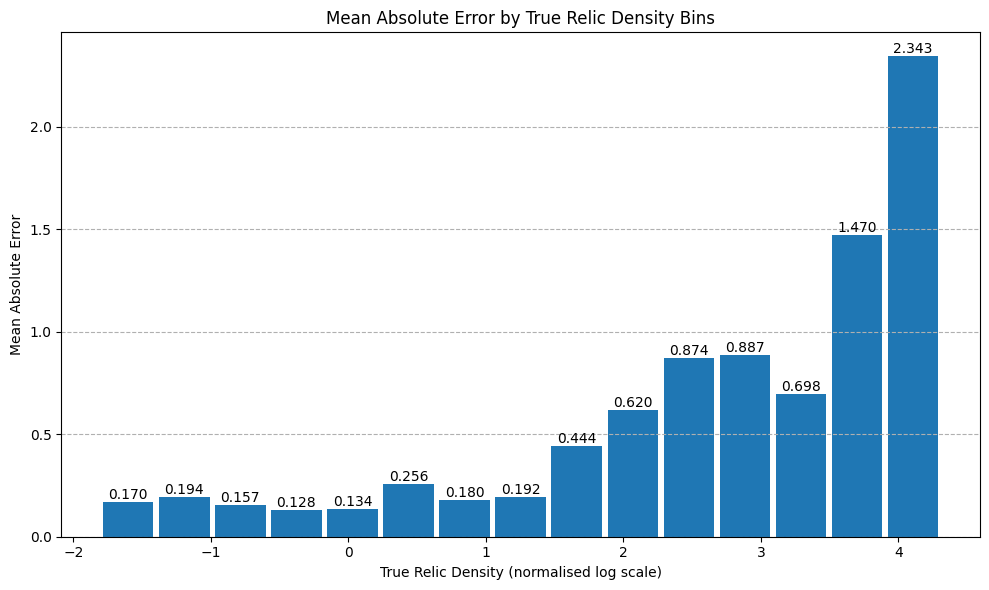

In [57]:
plot_mae_by_bins(targets, predictions, 15)

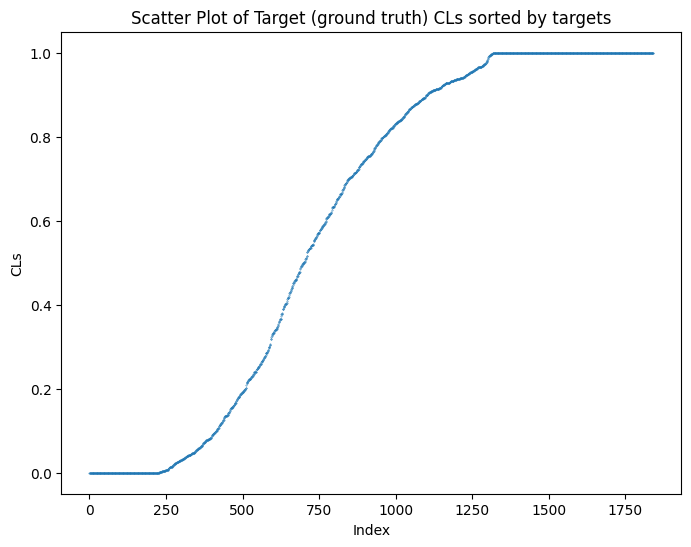

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(targets)), targets, s=0.1)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("CLs")
plt.title(f"Scatter Plot of Target (ground truth) CLs sorted by targets")

# Save the plot
# plt.savefig(f"plots/DM_predictor_performance/DM-targets.png")

# Show the plot
plt.show()

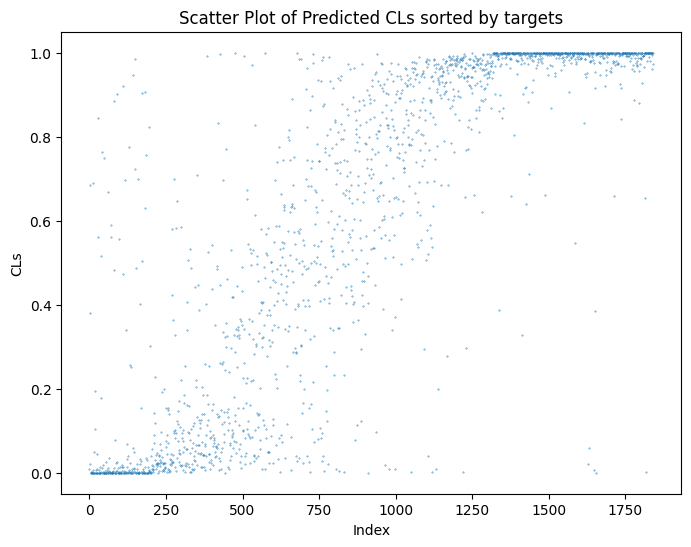

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(predictions)), predictions, s=0.1)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("CLs")
plt.title(f"Scatter Plot of Predicted CLs sorted by targets")

# Save the plot
# plt.savefig(f"plots/DM_predictor_performance/DM-predictions.png")

# Show the plot
plt.show()